# Centipede A tissue sequencing Metilene analysis
B.Gould
Feb 2021

In [1]:
from calzone import Calzone
from featureio import FeatureIO
from pineapple.contrib.components.data_factories.matrix_factory import MatrixFactory as mf

from pineapple.core import experiment_context
import datetime
experiment_context.reset_context(0, "x", "x", datetime.datetime(2021, 2, 2,0,0))

import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import os
import pickle
import numpy as np
import seaborn as sns

In [3]:
# see peter's notes for training classes: https://docs.google.com/document/d/1A1o-0W0iM6ejxvRcXLo_p8ysmuEWGbdtX3mZQlyHk1E/edit
# sequenced using the CpG_dense panel

In [4]:
with FeatureIO() as ftio:
    crc_dsids = ftio.get_datasets_for_training_class("colorectal_tissue_cancer_stage_IV_chemo_n")
    print(len(crc_dsids))
    
    lung_dsids = ftio.get_datasets_for_training_class("lung_cancer_methyl_DMR_tissue_ds_FF")
    print(len(lung_dsids))
    
    paad_dsids = ftio.get_datasets_for_training_class("pancreatic_cancer_tissue_ds_FF_v1")
    print(len(paad_dsids))
    
    prad_dsids = ftio.get_datasets_for_training_class("prostate_cancer_tissue_ds_FF_v1")
    print(len(prad_dsids))
    
    liver_dsids = ftio.get_datasets_for_training_class("liver_cancer_tissue_ds_FF_v1")
    print(len(liver_dsids))
    
    ov_dsids = ftio.get_datasets_for_training_class("ovarian_cancer_tissue_ds_FF_v1")
    print(len(ov_dsids))
    
    healthy_plasma_dsids = ftio.get_datasets_for_training_class("colorectal_plasma_healthy_discovery_polyp_n")
    print(len(healthy_plasma_dsids))

21
48
29
29
14
22
41


In [ ]:
# Batch 2 training classes:
kidney_cancer_tissue_ds_FF_v1
breast_cancer_tissue_ds_FF_v1
nonhodgkinslymphoma_cancer_tissue_ds_FF_v1
uterine_cancer_tissue_ds_FF_v1
stomach_cancer_tissue_ds_FF_v1

In [5]:
# location of tissue bams: gs://external-methyl-data/freenome_processed_data/cpg_dense_panel_bams/cpg_dense_panel_3mcpg_filtered_bams/

In [6]:
def write_mergefile(dsids, cancer_type):
    metadata = Calzone.get_dataset_metadata_with_ids(dsids)
    files = [m.raw_dataset_metadata['dataset']['raw_data_path'] for m in metadata]
    #stages = [m.raw_dataset_metadata[]]      
    with open(f"./{cancer_type}_bams_to_merge.txt","w") as fout:
        for file in files[0:14]:
            fout.write(file + "\n")


In [7]:
write_mergefile(lung_dsids, "lung")

Missed Redis cache for ttl_key TS-212492993, reading from BigQuery instead
Missed Redis cache for 48 datasets with timestamp 2021-02-02 20:31:55.109531, reading from BigQuery instead


In [8]:
write_mergefile(crc_dsids, "crc")
write_mergefile(paad_dsids, "paad")
write_mergefile(prad_dsids, "prad")
write_mergefile(ov_dsids, "ov")
write_mergefile(liver_dsids, "liver")

Missed Redis cache for 21 datasets with timestamp 2021-02-02 20:31:55.109531, reading from BigQuery instead
Missed Redis cache for 29 datasets with timestamp 2021-02-02 20:31:55.109531, reading from BigQuery instead
Missed Redis cache for 29 datasets with timestamp 2021-02-02 20:31:55.109531, reading from BigQuery instead
Missed Redis cache for 22 datasets with timestamp 2021-02-02 20:31:55.109531, reading from BigQuery instead
Missed Redis cache for 14 datasets with timestamp 2021-02-02 20:31:55.109531, reading from BigQuery instead


## ported all these to independent scripts
to run the full pipeline do:  
python make_metilene_inputs_tcga.py  
    --cancer_tcga_betas_path ./perprobebetas/{TYPE}\_450\_betas.txt  
    --out_prefix {TYPE}  
source run_metilene.sh  
python merge_DMRs.py --in_dir {TYPE}\_met\_inputs --out_bed {TYPE} #(filters regions by signif. thresholds)  
python make_clustermap.py  
    --cancer_tcga_betas_path ~/src/Methyl/TCGA/PanCancer/perprobebetas/{TYPE}\_450\_betas.csv  
    --title "{TYPE} metilene DMRs"  
    --bed_path {TYPE}\_met\_DMRs.tsv  


In [2]:
# Create Metilene input files

# healthy plasma
classes = ["colorectal_plasma_healthy_polyp_n","colorectal_plasma_healthy_polyp_y"]
mat_healthy_plasma = mf.create_from_training_classes(classes,
                                                    'per_cpg_hmcfc_min_5_cpg_dense/v1',
                                                     class_labels=[0,0])
mat_healthy_plasma.shape

(95, 2770507, 2)

In [3]:
# CRC tissue data
classes = ["colorectal_tissue_cancer_stage_III_chemo_n",
           "colorectal_tissue_cancer_stage_III_chemo_y",
           "colorectal_tissue_cancer_stage_IV_chemo_n",
           "colorectal_tissue_cancer_stage_IV_chemo_y"]
mat_crc = mf.create_from_training_classes(classes,
                                          'per_cpg_hmcfc_min_5_cpg_dense/v1',
                                          class_labels=[1,1,1,1])
mat_crc.shape

(40, 2770507, 2)

In [4]:
chrms = [m["chrom"] for m in mat_healthy_plasma.column_metadata]
pos = [m["end"] for m in mat_healthy_plasma.column_metadata]
sample_names = [f"g1_{i}" for i in range(mat_healthy_plasma.shape[0])]

df_healthies = pd.DataFrame(mat_healthy_plasma.x[:,:,0]/mat_healthy_plasma.x[:,:,1]).T
df_healthies.columns = sample_names
df_healthies["chr"] = chrms
df_healthies["pos"] = pos
cols = df_healthies.columns.to_list()
cols = cols[-2:] + cols[0:-2]
df_healthies = df_healthies[cols]
#df_healthies = df_healthies.fillna(".")
df_healthies.head()

#plt.hist(df_healthies.sum(axis=1))

,chr,pos,g1_0,g1_1,g1_2,g1_3,g1_4,g1_5,g1_6,g1_7,...,g1_85,g1_86,g1_87,g1_88,g1_89,g1_90,g1_91,g1_92,g1_93,g1_94
0,chr1,28736,NaN,0.0,NaN,0.0,NaN,0.0,NaN,NaN,...,NaN,0.0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,NaN
1,chr1,28750,0.0,0.0,NaN,0.0,NaN,0.0,NaN,NaN,...,NaN,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN
2,chr1,28752,0.0,0.0,NaN,0.0,NaN,0.0,NaN,NaN,...,NaN,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN
3,chr1,28765,0.0,0.0,NaN,0.0,NaN,0.0,NaN,NaN,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
4,chr1,28774,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


In [23]:
with open("./healthy_plasma_met_input.csv","w") as fout:
    df_healthies.to_csv(fout, sep=",", index=False)

In [16]:
# read in healthy data
with open("./healthy_plasma_met_input.csv","r") as fin:
    df_healthies = pd.read_csv(fin, sep=",",index_col=0, header=0)
print(df_healthies.head())

        pos g1_0 g1_1 g1_2 g1_3 g1_4 g1_5 g1_6 g1_7 g1_8  ... g1_85 g1_86  \
chr                                                       ...               
chr1  28736    .  0.0    .  0.0    .  0.0    .    .  0.0  ...     .   0.0   
chr1  28750  0.0  0.0    .  0.0    .  0.0    .    .  0.0  ...     .   0.0   
chr1  28752  0.0  0.0    .  0.0    .  0.0    .    .  0.0  ...     .   0.0   
chr1  28765  0.0  0.0    .  0.0    .  0.0    .    .  0.0  ...     .   0.0   
chr1  28774  0.0  0.0    .  0.0  0.0  0.0  0.0    .  0.0  ...     .   0.0   

     g1_87 g1_88 g1_89 g1_90 g1_91 g1_92 g1_93 g1_94  
chr                                                   
chr1   0.0     .     .     .   0.0   0.0   0.0     .  
chr1   0.0   0.0     .   0.0   0.0   0.0   0.0     .  
chr1   0.0   0.0     .   0.0   0.0   0.0   0.0     .  
chr1   0.0   0.0   0.0   0.0   0.0   0.0   0.0     .  
chr1   0.0   0.0   0.0   0.0   0.0   0.0   0.0     .  

[5 rows x 96 columns]


In [12]:
def make_input_df(matrix, title):
    sample_names = [f"g2_{i}" for i in range(matrix.shape[0])]
    df = pd.DataFrame(matrix.x[:,:,0]/matrix.x[:,:,1]).T
    df.columns = sample_names
    print("Fill NA . . .")
    df = df.fillna(".")
    print("Complete fill na. ")
    df_met = pd.concat([df_healthies, df], axis=1)
    print(df_met.head())
    print(df_met.shape)
    
    #with open(f"./{title}_tissue_met_input.tsv", "w") as fout:
    #    df_met.to_csv(fout, sep="\t", index=False)
    print("Complete")
    return df_met

In [10]:
def split_by_chr(input_df, title):
    !mkdir -p {title}_met_chr_inputs
    for i in range(1,23):
        df_chr = input_df[input_df["chr"]==f"chr{i}"]
        with open(f"./{title}_met_chr_inputs/{title}_chr{i}.tsv","w") as fout:
            df_chr.to_csv(fout, index=False, sep="\t")
            print(f"Chr{i} complete.")
    return
                          

In [17]:
# This step has taken most of a day . . . why? fillna?
df_crc = make_input_df(mat_crc, "CRC")

Fill NA . . .
Complete fill na. 


KeyboardInterrupt: 

In [15]:
split_by_chr(df_crc, "CRC")

Chr1 complete.


KeyboardInterrupt: 

In [ ]:
print(df_crc.head())
# with open(f"./CRC_tissue_met_input.tsv", "w") as fout:
#         df_crc.to_csv(fout, sep="\t", index=False)

In [7]:
df_crc = pd.read_csv("./CRC_tissue_met_input.tsv", header=0,sep="\t")
df_crc = df_crc.fillna(".")
print(df_crc.head())

    chr    pos g1_0 g1_1 g1_2 g1_3 g1_4 g1_5 g1_6 g1_7  ... g2_30 g2_31 g2_32  \
0  chr1  28736    .  0.0    .  0.0    .  0.0    .    .  ...     .     .     .   
1  chr1  28750  0.0  0.0    .  0.0    .  0.0    .    .  ...     .     .     .   
2  chr1  28752  0.0  0.0    .  0.0    .  0.0    .    .  ...     .     .     .   
3  chr1  28765  0.0  0.0    .  0.0    .  0.0    .    .  ...     .     .     .   
4  chr1  28774  0.0  0.0    .  0.0  0.0  0.0  0.0    .  ...     .     .     .   

  g2_33 g2_34 g2_35 g2_36 g2_37 g2_38 g2_39  
0     .     .     .     .     .     .     .  
1     .     .     .     .     .     .     .  
2     .     .     .     .     .     .     .  
3     .     .     .     .     .     .     .  
4     .     .     .     .     .     .     .  

[5 rows x 137 columns]


In [15]:
split_by_chr(df_crc, "CRC")

Chr1 complete.
Chr2 complete.
Chr3 complete.
Chr4 complete.
Chr5 complete.
Chr6 complete.
Chr7 complete.
Chr8 complete.
Chr9 complete.
Chr10 complete.
Chr11 complete.
Chr12 complete.
Chr13 complete.
Chr14 complete.
Chr15 complete.
Chr16 complete.
Chr17 complete.
Chr18 complete.
Chr19 complete.
Chr20 complete.
Chr21 complete.
Chr22 complete.


In [ ]:

# ./../Metilene/metilene_v0.2-8/metilene -a g1 -b g2 CRC_tissue_met_input_nona.tsv >CRC_met_DMRs.txt

In [34]:
classes = ["pancreatic_cancer_tissue_ds_FF_v1"]
mat = mf.create_from_training_classes(classes,
                                      'per_cpg_hmcfc_min_5_cpg_dense/v1',
                                       class_labels=[1])
print(mat.shape)

make_input_df(mat, "Pancreas")

Missed Redis cache for 29 datasets with timestamp 2021-02-02 00:00:00, reading from BigQuery instead


(29, 2770507, 2)
    chr    pos  g1_0  g1_1  g1_2  g1_3  g1_4  g1_5  g1_6  g1_7  ...  g2_19  \
0  chr1  28736   NaN   0.0   NaN   0.0   NaN   0.0   NaN   NaN  ...      .   
1  chr1  28750   0.0   0.0   NaN   0.0   NaN   0.0   NaN   NaN  ...      .   
2  chr1  28752   0.0   0.0   NaN   0.0   NaN   0.0   NaN   NaN  ...      .   
3  chr1  28765   0.0   0.0   NaN   0.0   NaN   0.0   NaN   NaN  ...      .   
4  chr1  28774   0.0   0.0   NaN   0.0   0.0   0.0   0.0   NaN  ...      .   

   g2_20  g2_21  g2_22  g2_23  g2_24  g2_25  g2_26  g2_27  g2_28  
0      .      .      .      .      .      .      .      .      .  
1      .      .      .      .      .      .      .      .      .  
2      .      .      .      .      .      .      .      .      .  
3      .      .      .      .      .      .      .      .      .  
4      .      .      .      .      .      .      .      .      .  

[5 rows x 126 columns]
(2770507, 126)
Complete


In [18]:
# df_pan = pd.read_csv("./Pancreas_tissue_met_input.tsv", header=0,sep="\t")
# df_pan = df_pan.fillna(".")
# print(df_pan.head())
split_by_chr(df_pan, "Pancreas")

Chr1 complete.
Chr2 complete.
Chr3 complete.
Chr4 complete.
Chr5 complete.
Chr6 complete.
Chr7 complete.
Chr8 complete.
Chr9 complete.
Chr10 complete.
Chr11 complete.
Chr12 complete.
Chr13 complete.
Chr14 complete.
Chr15 complete.
Chr16 complete.
Chr17 complete.
Chr18 complete.
Chr19 complete.
Chr20 complete.
Chr21 complete.
Chr22 complete.


In [ ]:
# | chr | start | stop | q-value | mean methylation difference | #CpGs | p (MWU) | p (2D KS) | mean g1 | mean g2

files = !ls ./CRC_met_chr_inputs/*_DMRs.txt
dfs = []
for file in files:
    df = pd.read_csv(file, sep="\t", header=None)
    print(df.head())
    df = df[df.iloc[:,3]<0.05]
    df = df[df.iloc[:,4]<0]
    df = df[df.columns[0:3]]
    dfs.append(df)

df_all = pd.concat(dfs)
print(df_all.shape)
print(df_all.head())

with open("./CRC_all_DMRs.bed","w") as fout:
    df_all.to_csv(fout, index=False, sep="\t")

## ported all these to independent scripts
#Run:
python make_metilene_inputs.py --training_class ovarian_cancer_tissue_ds_FF_v1 --out_prefix Ovarian
source run_metilene.sh Ovarian_met_chr_inputs
python merge_DMRs.py --in_dir Ovarian_met_chr_inputs --out_bed Ovarian_all_DMRs.tsv

# Make heatmaps of each region set output by metilene


In [ ]:
# load bedfile of DMRs
# load tissue tcga beta values
# load blood epic beta values
# for each region in bed extract all probe values for each sample in tissue
# for each region in bed extract all probe values for each sample in blood
# merge dict of region averages into DataFrame and plot as heat map.


In [41]:
matrix_bld=pd.read_csv("/home/billiegould/src/Methyl/TCGA/PanCancer/perprobebetas/GSE110555_blood_EPIC_betas.txt", sep="\t")
print(matrix_bld.shape)
matrix_bld.head()

(865918, 68)


,ProbeID,GSM2995280_201868590258_R01C01,GSM2995281_201868590099_R04C01,GSM2995282_201868590099_R07C01,GSM2995283_201868590099_R03C01,GSM2995284_201868590258_R04C01,GSM2995285_201868590099_R08C01,GSM2995286_201868590099_R02C01,GSM2995287_201868590099_R05C01,GSM2995288_201868590099_R01C01,...,GSM2998140_201870610111_R04C01,GSM2998143_201870610111_R05C01,GSM2998146_201870610111_R06C01,GSM2998149_201870610111_R07C01,GSM3074480_202163530006_R02C01,GSM3074481_202163530006_R03C01,GSM3074482_202163530006_R04C01,GSM3074483_202163530006_R06C01,GSM3074484_202163530006_R07C01,GSM3074485_202163530006_R08C01
0,cg18478105,0.023924,0.021267,0.016215,0.015554,0.021642,0.015237,0.018368,0.016891,0.018232,...,0.015454,0.018249,0.021805,0.018219,0.018538,0.033569,0.021886,0.017784,0.015673,0.017795
1,cg01763666,0.716950,0.788641,0.757762,0.768896,0.792459,0.763830,0.804868,0.759402,0.814085,...,0.603830,0.933529,0.653003,0.695979,0.770630,0.760713,0.782767,0.752489,0.799943,0.796192
2,cg25813447,0.068839,0.049029,0.050133,0.047702,0.049845,0.053604,0.038454,0.062210,0.061132,...,0.159036,0.029493,0.146008,0.037188,0.043401,0.054012,0.078437,0.048994,0.363894,0.070873
3,cg07779434,0.033854,0.027169,0.026531,0.031166,0.033587,0.023341,0.027100,0.026527,0.028244,...,0.029501,0.034909,0.028853,0.027230,0.035515,0.032339,0.026009,0.028557,0.375870,0.022654
4,cg13417420,0.045786,0.082441,0.048532,0.055085,0.110833,0.069514,0.065422,0.076870,0.072224,...,0.038987,0.027935,0.053702,0.040571,0.039559,0.166436,0.036245,0.025067,0.088086,0.101406


In [44]:
# load probe locations
probe_coord = pickle.load(open("/home/billiegould/src/Methyl/TCGA/df_keep_probes_metadata.pkl","rb"))
probe_coord.head()

probe_dict = dict(zip(probe_coord.index, zip(probe_coord["Chromosome"],probe_coord["End"])))

In [187]:
# filter epic probes
matrix_bld_filtered = matrix_bld[[p in probe_dict.keys() for p in matrix_bld["ProbeID"]]]
matrix_bld_filtered.shape
matrix_bld_filtered = matrix_bld_filtered.set_index("ProbeID")
with open("./healthy_plasma_epic_betas_probe_filtered.csv","w") as fout:
    matrix_bld_filtered.to_csv(fout, sep=",", index=True)

In [188]:
print(matrix_bld_filtered.head())

            GSM2995280_201868590258_R01C01  GSM2995281_201868590099_R04C01  \
ProbeID                                                                      
cg18478105                        0.023924                        0.021267   
cg01763666                        0.716950                        0.788641   
cg13417420                        0.045786                        0.082441   
cg24133276                        0.042326                        0.057300   
cg11073926                        0.076858                        0.078377   

            GSM2995282_201868590099_R07C01  GSM2995283_201868590099_R03C01  \
ProbeID                                                                      
cg18478105                        0.016215                        0.015554   
cg01763666                        0.757762                        0.768896   
cg13417420                        0.048532                        0.055085   
cg24133276                        0.059702                     

In [178]:
# ported all code to make_clustermap.py

def load_bed(bed_path):
    regions = []
    with open(bed_path, "r") as fin:
        for line in fin.readlines():
            regions.append(line.strip().split("\t"))
    return regions

def filter_out_healthy_samples(tcga_beta_matrix):
    matrix_t = tcga_beta_matrix.T
    #print(matrix_t.head())
    sample_filter = []
    for name, row in matrix_t.iterrows():
        #print(name)
        #print(matrix_t.shape)
        # drop healthy samples from data set
        tcga_sample = int(name.split("-")[3][0:2])
        if tcga_sample in range(10,30):
            sample_filter.append(False)
        else:
            sample_filter.append(True)
    matrix_f_sam = matrix_t.loc[sample_filter, :]
    return matrix_f_sam

# first load filtered blood data, and probe dict above
def make_clustermap(cancer_tcga_betas_path, bed_path, title):
    reg_avg_sample_betas = {}
    
    #load cancer tcga data and filter
    df_cancer = pd.read_csv(cancer_tcga_betas_path, sep="\t")
    df_cancer = df_cancer.set_index("ProbeID")
    df_cancer = filter_out_healthy_samples(df_cancer) #samples x probes
    #print(df_cancer.T.shape) # probes x samples
    df_cancer = df_cancer.T.iloc[0:10000,0:4] #probes x samples #test
    #print(df_cancer.shape)  
    df_cancer = df_cancer[[p in list(probe_dict.keys()) for p in df_cancer.index]]
    
    #filter for overlapping 450 and EPIC probes
    overlapping_probes = set(matrix_bld_filtered.index).intersection(set(df_cancer.index))
    df_cancer = df_cancer[[p in overlapping_probes for p in df_cancer.index]]
    df_healthy = matrix_bld_filtered[[p in overlapping_probes for p in matrix_bld_filtered.index]]
    print(df_cancer.shape)
    print(df_healthy.shape)
    
    regions = load_bed(bed_path)
    
    i = 0
    for chrm,start,stop in regions[0:100]: # test
        start = int(start)
        stop = int(stop)
        df_cancer_reg = df_cancer[[probe_dict[p][0]==chrm for p in df_cancer.index]]
        df_cancer_reg = df_cancer[[(start <= probe_dict[p][1] <= stop) for p in df_cancer.index]]
        #print(df_healthy_reg.head())
        #print(f"{chrm},{start},{stop}")
        #print(df_healthy.shape)
        df_healthy_reg = df_healthy.iloc[0:10000,0:4] #test
        df_healthy_reg = df_healthy[[probe_dict[p][0]==chrm for p in df_healthy.index]]
        df_healthy_reg = df_healthy_reg[[(start <= probe_dict[p][1] <= stop) for p in df_healthy_reg.index]]
        if df_cancer_reg.shape[0] == df_healthy_reg.shape[0] == 0:
            i += 1
            if i %10 == 0:
                print(f"{i} regions complete")
            continue
        #print(df_cancer_reg.head())
        #print(df_healthy_reg.head())
        reg_avg_sample_betas[(chrm,start,stop)] = list(np.median(df_cancer_reg, axis=0))
        reg_avg_sample_betas[(chrm,start,stop)].extend(np.median(df_healthy_reg, axis=0))
        i += 1
        if i %10 == 0:
            print(f"{i} regions complete")
    df_reg_avg_betas = pd.DataFrame.from_dict(reg_avg_sample_betas, orient="index") # samples x regions
    df_reg_avg_betas = df_reg_avg_betas.fillna(-0.001)
    print(df_reg_avg_betas.head())

    col_colors= np.concatenate([np.repeat("red",df_cancer.shape[1]), np.repeat("blue",df_healthy.shape[1])])
    #print(col_colors)
    c = sns.clustermap(data=df_reg_avg_betas.T, 
                       method="ward",
                       metric="euclidean",
                       mask= df_heatmap < 0,
                       col_colors = col_colors,
                       xticklabels = [],
                       yticklabels = [],
                      )
    c.ax_heatmap.set_xlabel('Samples',size=16)
    c.ax_heatmap.set_ylabel('Regions',size=16)
    c.fig.suptitle('PAAD Metilene DMRs', size=16)
    col_dict = {"Cancer":"red","Healthy Plasma":"blue"}
    for label in list(col_dict.keys()):
        c.ax_col_dendrogram.bar(0, 0, color=col_dict[label],
                                label=label, linewidth=0)
    c.ax_col_dendrogram.legend(loc="top right")
    plt.title(f"{title}")
    return df_reg_avg_betas
    
    

(8738, 4)
(8738, 67)
10 regions complete
20 regions complete
30 regions complete
40 regions complete
50 regions complete
60 regions complete
70 regions complete
80 regions complete
90 regions complete
100 regions complete
                                0         1         2         3         4   \
(chr1, 919531, 919690)    0.851678  0.885970  0.622417  0.849665 -0.001000   
(chr1, 943664, 944129)    0.772144  0.777252  0.810647  0.852305  0.964279   
(chr1, 1121120, 1121464)  0.761965  0.577993  0.621957  0.839907 -0.001000   
(chr1, 1130434, 1130802)  0.296122  0.247090  0.277403  0.603418  0.956972   
(chr1, 1148766, 1148965)  0.959155  0.946993  0.955455  0.931836 -0.001000   

                                5         6         7         8         9   \
(chr1, 919531, 919690)   -0.001000 -0.001000 -0.001000 -0.001000 -0.001000   
(chr1, 943664, 944129)    0.971316  0.972556  0.976589  0.976457  0.978127   
(chr1, 1121120, 1121464) -0.001000 -0.001000 -0.001000 -0.001000 -0.001000 

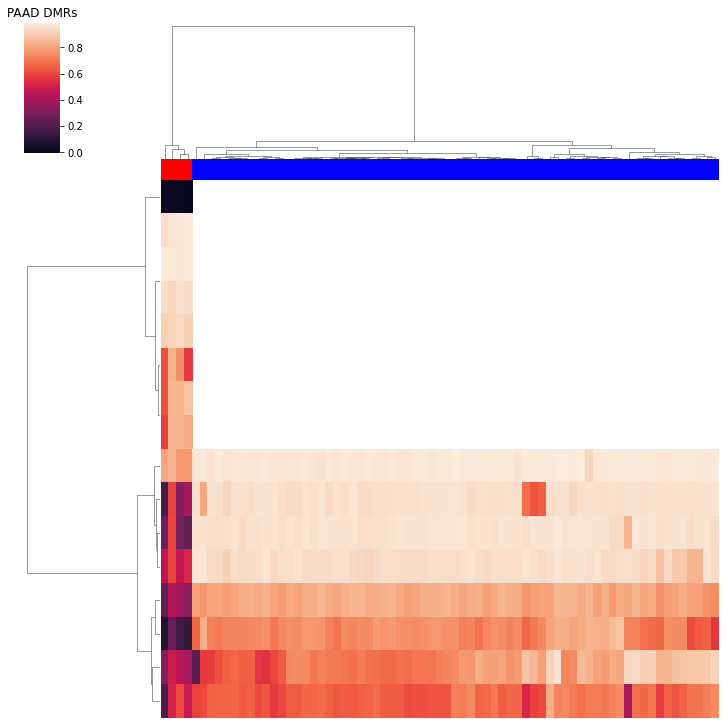

In [179]:
df_heatmap = make_clustermap(cancer_tcga_betas_path = "/home/billiegould/src/Methyl/TCGA/PanCancer/perprobebetas/PAAD_450_betas.txt",
                bed_path="./Pancreas_all_DMRs.bed",
                title = "PAAD DMRs")

In [21]:
# what type of kidney cancer do we have?
with FeatureIO() as ftio:
    kidney_dsids = ftio.get_datasets_for_training_class("kidney_cancer_tissue_ds_FF_v1")
    print(len(kidney_dsids))
    

25


In [22]:
m = Calzone.get_dataset_metadata_with_ids(kidney_dsids)

Missed Redis cache for ttl_key TS-212495026, reading from BigQuery instead
Missed Redis cache for 25 datasets with timestamp 2021-02-09 12:09:30.259622, reading from BigQuery instead


In [41]:
import json
from collections import Counter

In [42]:
Counter([json.loads(md.raw_sample_metadata["json_dump"])["diagnoses"][0]["pathologic_type"] for md in m])

Counter({'Renal cell carcinoma': 23,
         'Transitional cell carcinoma': 1,
         'Papillary transitional cell carcinoma': 1})

In [43]:
#what type of uterine cancer?
with FeatureIO() as ftio:
    uterine_dsids = ftio.get_datasets_for_training_class("uterine_cancer_tissue_ds_FF_v1")
    print(len(uterine_dsids))
    
m = Calzone.get_dataset_metadata_with_ids(uterine_dsids)
Counter([json.loads(md.raw_sample_metadata["json_dump"])["diagnoses"][0]["pathologic_type"] for md in m])

Missed Redis cache for ttl_key TS-212495036, reading from BigQuery instead


25


Missed Redis cache for 25 datasets with timestamp 2021-02-09 12:09:30.259622, reading from BigQuery instead


Counter({'Carcinoma': 1,
         'Sarcoma': 1,
         'Carcinoma - Endometrioid type': 9,
         'Carcinosarcoma': 6,
         'Squamous cell carcinoma': 3,
         'Clear cell adenocarcinoma': 2,
         'Carcinoma - Serous type': 3})

In [45]:
[md.raw_dataset_metadata["dataset"]["sample_id"] for md in m]


[104102,
 104153,
 104149,
 104083,
 104294,
 104309,
 104043,
 104311,
 104086,
 104150,
 104112,
 103959,
 104310,
 104125,
 104044,
 103988,
 104099,
 104126,
 103989,
 104136,
 104307,
 104088,
 104292,
 104266,
 104130]

In [51]:
from pybedtools import BedTool

In [50]:
# Find overlaps with VP2 and CpG lite panel.
in_bed = pd.read_csv("./CRC_all_DMRs.bed", header=None, sep="\t")
in_bed_size = sum(in_bed.iloc[:,2] - in_bed.iloc[:,1])
with open("./CRC_all_DMRs_3.bed","w") as fout:
    in_bed.iloc[:,0:3].to_csv(fout, sep="\t",index=False, header=False)

In [77]:
# return regions in a that overlap with b
met_bed = "CRC_all_DMRs_3.bed"
cpg_bed = "cpg_dense_v2_candidate_with_lung_with_atac_ignore_blood_withv4.bed"
vp2_bed = "Panel1_CRC_Multicancer_hctonregions_hypermethylatedhealthycontrols_combined.bed"

#overlapping_reg_cpg = met_bed.intersect(cpg_bed, u=True, w=True, o=True).saveas("./intersect_cpg.bed")
!bedtools intersect -a {met_bed} -b {cpg_bed} -wo > intersect_cpg.bed

#overlapping_reg_vp2 = met_bed.intersect(vp2_bed, u=True, w=True, o=True)
!bedtools intersect -a {met_bed} -b {vp2_bed} -wo > intersect_vp2.bed

def overlap_size(intersect_file):
    with open(f"./{intersect_file}", "r") as fin:
        size = 0
        for line in fin.readlines():
            #print(line)
            size += int(line.split("\t")[6].strip())
    return float(size)


def panel_size(region_set):
    size = 0
    for feature in region_set:
        size += feature.stop - feature.start
        #size += feature.fields[6] # the last field of intersect is overlapping bps
    return float(size)

pct_overlap_cpg = overlap_size("intersect_cpg.bed")/ panel_size(BedTool(met_bed))

pct_overlap_VP2 = overlap_size("intersect_vp2.bed")/ panel_size(BedTool(met_bed))

print(f"CRC percent overap CpG Lite: {pct_overlap_cpg}. VP2: {pct_overlap_VP2}")

CRC percent overap CpG Lite: 0.6999611128576388. VP2: 0.05130737529668208


In [5]:
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt

In [3]:
# make a distance matrix between metilene regions for all cancers
cancers = ["Breast","Kidney","Lymphoma","Uterine","Stomach",
          "CRC","Prostate","Pancreas","Liver","Ovarian"]

match_lists = []
for cancer1 in cancers:
    file1 = f"{cancer1}_all_DMRs_3.bed"
    n_file1 = !wc -l {file1}
    n_file1 = int(str(n_file1).split()[0][2:])
    matches = []
    for cancer2 in cancers:
        file2 = f"{cancer2}_all_DMRs_3.bed"
        !bedtools intersect -a {file1} -b {file2} > tmp.bed #all overlapping regions
        match = !wc -l tmp.bed
        n_file2 = !wc -l {file2}
        n_file2 = int(str(n_file2).split()[0][2:])
        match = int(str(match).split()[0][2:])
        pct_overlap = match/((n_file1 + n_file2)/2.0)
        matches.append(pct_overlap)
    match_lists.append(matches)
    print(f"{cancer1} complete")

df_matches = pd.DataFrame(match_lists)
df_matches.columns = cancers
df_matches.index = cancers

df_matches

Breast complete
Kidney complete
Lymphoma complete
Uterine complete
Stomach complete
CRC complete
Prostate complete
Pancreas complete
Liver complete
Ovarian complete


,Breast,Kidney,Lymphoma,Uterine,Stomach,CRC,Prostate,Pancreas,Liver,Ovarian
Breast,1.000000,0.421774,0.705172,0.764857,0.795697,0.802580,0.670011,0.449330,0.681377,0.563481
Kidney,0.421774,1.000000,0.243936,0.546115,0.451781,0.392648,0.577635,0.667639,0.408736,0.648918
Lymphoma,0.705172,0.243936,1.000000,0.587678,0.687868,0.805843,0.453849,0.270762,0.575176,0.366682
Uterine,0.764857,0.546115,0.587678,1.000000,0.767050,0.740645,0.680236,0.559682,0.597855,0.751233
Stomach,0.795697,0.451781,0.687868,0.767050,1.000000,0.856396,0.583199,0.531242,0.651359,0.611412
CRC,0.802580,0.392648,0.805843,0.740645,0.856396,1.000000,0.579593,0.439094,0.643641,0.521840
Prostate,0.670011,0.577635,0.453849,0.680236,0.583199,0.579593,1.000000,0.596307,0.547919,0.635294
Pancreas,0.449330,0.667639,0.270762,0.559682,0.531242,0.439094,0.596307,1.000000,0.423043,0.678436
Liver,0.681377,0.408736,0.575176,0.597855,0.651359,0.643641,0.547919,0.423043,1.000000,0.466871
Ovarian,0.563481,0.648918,0.366682,0.751233,0.611412,0.521840,0.635294,0.678436,0.466871,1.000000


Text(0.5, 1.0, 'Fraction DMR overlap (tissues)')

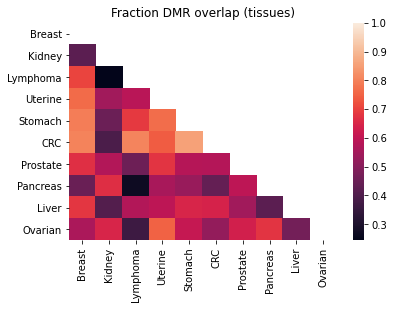

In [6]:
matrix = np.triu(df_matches)
plt.figsize=(20,20)
sns.heatmap(df_matches, mask=matrix)
plt.title("Fraction DMR overlap (tissues)")

## Compare size distributions of tissue metilene regions, TCGA metilene regions, and Autosegmentation regions.

In [8]:
# find overlaps by tissue type
# create sorted beds first
import os

cancer_types = ["Pancreas","Prostate","Liver","Kidney","Ovarian","Lung","Breast","Uterine","CRC","Lymphoma","Stomach"]

for cancer in cancer_types:
    cancer_met_file = f"./{cancer}_all_DMRs_3.bed_sort"
    cancer_auto_file = f"./autoseg_beds/{cancer}_autoseg_reg.bed_sort"
    sum1 = 0
    sum2 = 0
    i = 0
    j = 0
    for line in open(cancer_met_file,"r").readlines():
        #print(line.split("\t"))
        sum1 += int(line.split("\t")[2]) - int(line.split("\t")[1])
        i += 1
    print(f"{cancer_met_file}: {sum1} {i}")
    for line in open(cancer_auto_file,"r").readlines():
        #print(line.split("\t"))
        sum2 += int(line.split("\t")[2]) - int(line.split("\t")[1])
        j += 1
    print(f"{cancer_auto_file}: {sum2} {j}")
    
    os.system(f"bedtools intersect -a {cancer_met_file} -b {cancer_auto_file} -wao >tmp.bed")
    try:
        sum3 = 0
        for line in open("tmp.bed","r").readlines():
            #print(line.split("\t"))
            sum3 += int(line.split("\t")[6]) #use this for Batch 2 cancers
            #sum3 += int(line.split("\t")[7]) #use this for Batch 1 cancers
    except IndexError:
        sum3 = 0
    pct_overlap = sum3/float(sum1)
    !rm tmp.bed
    print(pct_overlap)

./Pancreas_all_DMRs_3.bed_sort: 1312143 2329
./autoseg_beds/Pancreas_autoseg_reg.bed_sort: 1536750 2973
0.0
./Prostate_all_DMRs_3.bed_sort: 2657151 4711
./autoseg_beds/Prostate_autoseg_reg.bed_sort: 926887 1888
0.0
./Liver_all_DMRs_3.bed_sort: 2687967 6871
./autoseg_beds/Liver_autoseg_reg.bed_sort: 932121 2137
0.0
./Kidney_all_DMRs_3.bed_sort: 1203152 2470
./autoseg_beds/Kidney_autoseg_reg.bed_sort: 206912 489
0.019201231432105004
./Ovarian_all_DMRs_3.bed_sort: 1631357 2939
./autoseg_beds/Ovarian_autoseg_reg.bed_sort: 667170 1415
0.0
./Lung_all_DMRs_3.bed_sort: 847188 1416
./autoseg_beds/Lung_autoseg_reg.bed_sort: 2188407 3969
0.0
./Breast_all_DMRs_3.bed_sort: 3412210 7450
./autoseg_beds/Breast_autoseg_reg.bed_sort: 957409 2079
0.10850211446540511
./Uterine_all_DMRs_3.bed_sort: 2951127 4968
./autoseg_beds/Uterine_autoseg_reg.bed_sort: 1508082 2982
0.11681808339661424
./CRC_all_DMRs_3.bed_sort: 4467406 7432
./autoseg_beds/CRC_autoseg_reg.bed_sort: 3589877 5556
0.0
./Lymphoma_all_DMRs_3.

<ipython-input-33-b615efa9b3d3>:36: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend(plts,     # The line objects


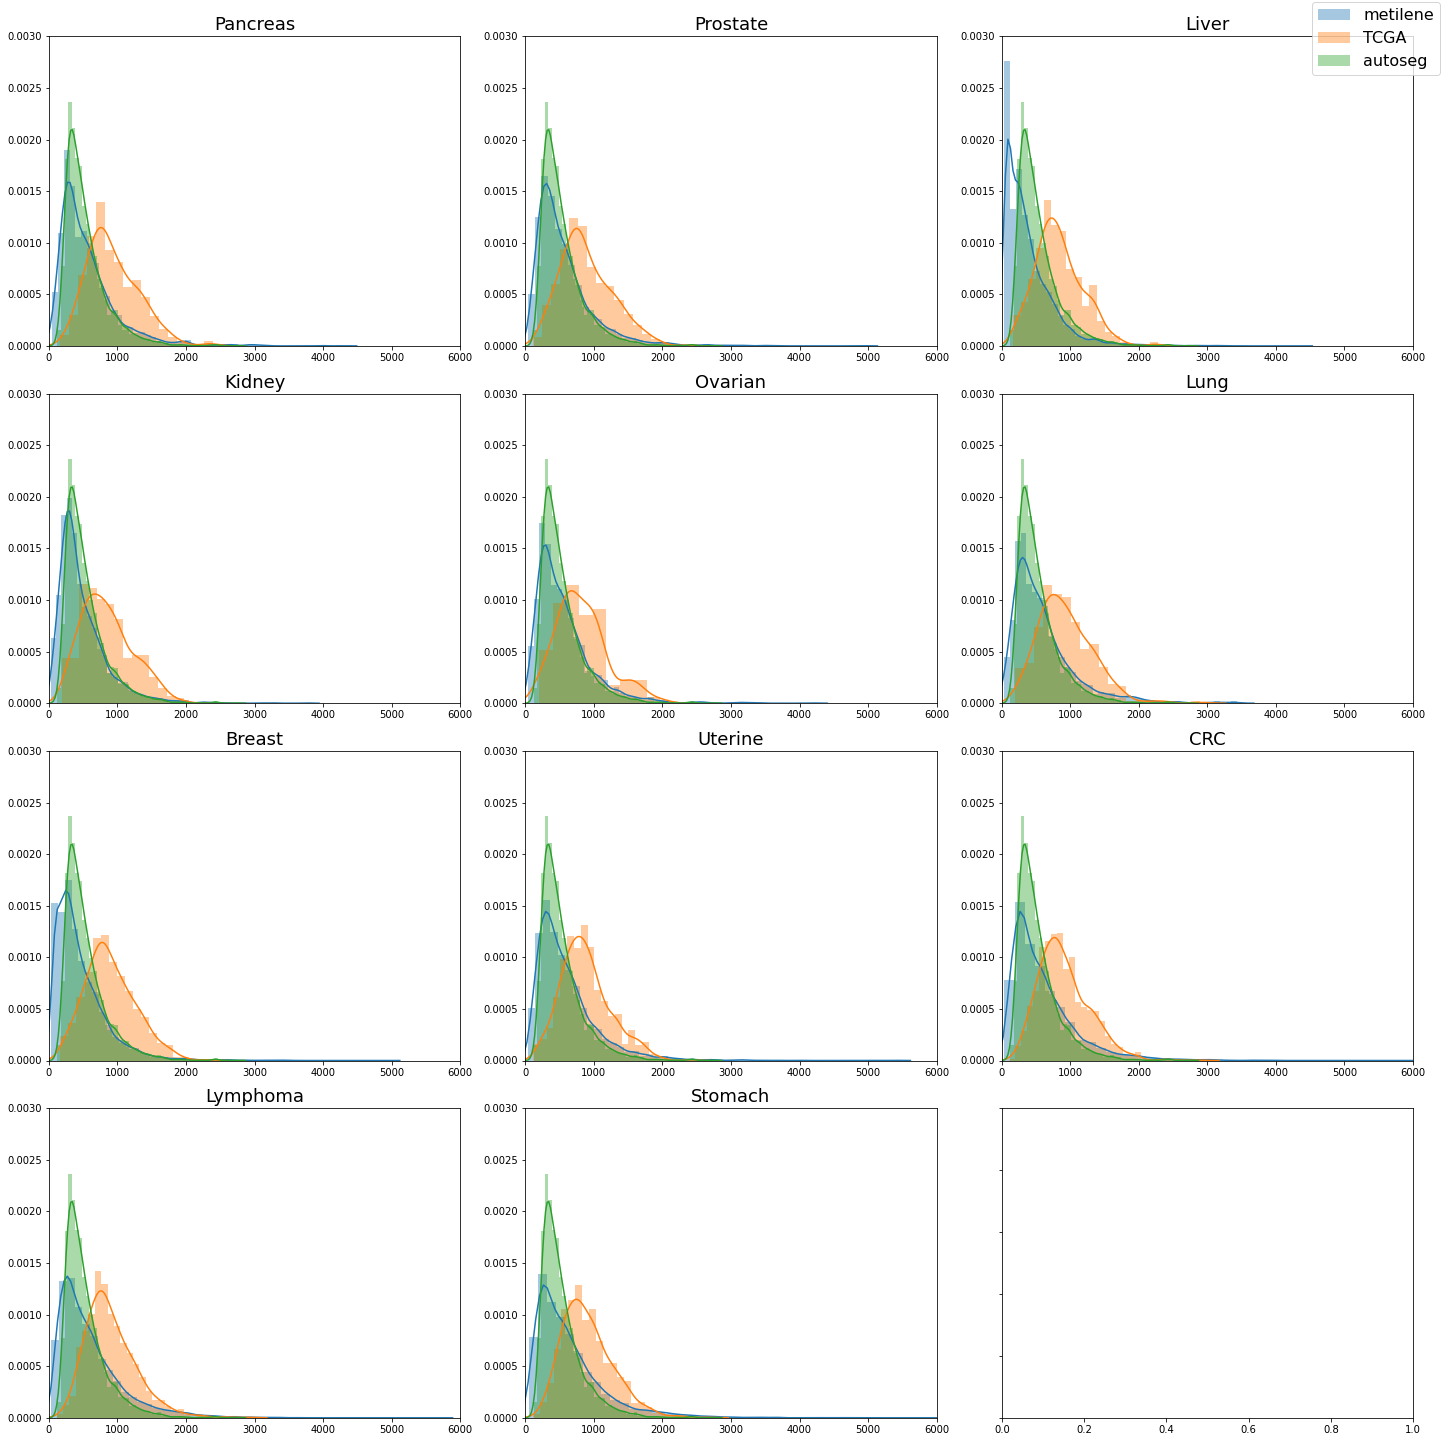

In [33]:
# find overlap btw tissue and tcga metilene dMRs
import seaborn as sns
from matplotlib import pyplot as plt

cancer_types = ["Pancreas","Prostate","Liver","Kidney","Ovarian","Lung","Breast","Uterine","CRC","Lymphoma","Stomach"]
tcga_types = ["PAAD","PRAD","LIHC","KI","OV","LUAD","BRCA","UC","CO_RE","DLBC","STAD"]

fig, ax = plt.subplots(nrows=4,ncols=3, figsize=(20,20),sharey=True)
plts = []
for i,(tissue,tcga_abrv) in enumerate(zip(cancer_types,tcga_types)):
    cancer_met_file = f"./{tissue}_all_DMRs_3.bed_sort"
    cancer_tcga_file = f"../TCGA/PanCancer/{tcga_abrv}_met_DMRS_filtered_3.bed_sort"
    cancer_auto_file = f"./autoseg_beds/{cancer}_autoseg_reg.bed_sort"
    tiss = []
    tcga = []
    auto = []
    for line in open(cancer_met_file,"r").readlines():
        #print(line.split("\t"))
        tiss.append(int(line.split("\t")[2]) - int(line.split("\t")[1]))
    for line in open(cancer_tcga_file,"r").readlines():
        #print(line.split("\t"))
        tcga.append(int(line.split("\t")[2]) - int(line.split("\t")[1]))
    for line in open(cancer_auto_file, "r").readlines():
        auto.append(int(line.split("\t")[2]) - int(line.split("\t")[1]))
    
    plt.subplot(4,3,i+1)
    plt.xlim([0,6000])
    plt.ylim([0,0.0030])
    s = sns.distplot(tiss)
    sns.distplot(tcga)
    sns.distplot(auto)
    plt.title(f"{tissue}", size=18)
    plts.append(s)

plt.tight_layout()
fig.legend(plts,     # The line objects
           labels=["metilene","TCGA","autoseg"],   # The labels for each line
           loc="upper right",   # Position of legend
           borderaxespad=0.1,    # Small spacing around legend box
           fontsize=16)


In [ ]:
# plot size distributions
cancer_types = ["Pancreas","Prostate","Liver","Kidney","Ovarian","Lung","Breast","Uterine","CRC","Lymphoma","Stomach"]
tcga_types = ["PAAD","PRAD","LIHC","KI","OV","LUAD","BRCA","UC","CO_RE","DLBC","STAD"]
for tissue,tcga_abrv in zip(cancer_types,tcga_types):
    cancer_met_file = f"./{tissue}_all_DMRs_3.bed_sort"
    cancer_tcga_file = f"../TCGA/PanCancer/{tcga_abrv}_met_DMRS_filtered_3.bed_sort"
    cancer_autoseg_file = f"
    sum1 = 0
    sum2 = 0
    i = 0
    j = 0
    for line in open(cancer_met_file,"r").readlines():
        #print(line.split("\t"))
        sum1 += int(line.split("\t")[2]) - int(line.split("\t")[1])
        i += 1
    print(f"{cancer_met_file}: {sum1} {i}")
    for line in open(cancer_tcga_file,"r").readlines():
        #print(line.split("\t"))
        sum2 += int(line.split("\t")[2]) - int(line.split("\t")[1])
        j += 1